In [1]:
import sys
sys.path.insert(0,'..')

from src.definitions import *
from src.plotting import *
from src.processing import *
from src.stats import *
from src.figures import *
from tqdm.notebook import tqdm


once_df = load_once_complete()
weekly_df = load_weekly()
biweekly_df = load_biweekly()
monthly_df = load_monthly()

sleep_df = load_sleep()
garmin_df = load_garmin_subset()
merged_df = load_merge_all_nogarmin()

daily = ["daily_stress_measure.csv.gz", "cough_ema.csv.gz", "selfassessment_mannequin_sam.csv.gz",
        "ppe_and_exposure_scale.csv.gz"]

weekly = ["perceived_stress_scale_pss4.csv.gz", "promis_sleep_disturbance_sd.csv.gz",
         "promis_sleeprelated_impairment_sri.csv.gz", "ongoing_covid19_risk.csv.gz",
         "fatigue_severity_scale_fss9.csv.gz", "cough_vas.csv.gz"]

monthly = ["promis_global10.csv.gz", "promis_emotional_support.csv.gz", "rand_36item_short_form_health_survey.csv.gz",
          "survey_response_inclination_sri.csv.gz"]

other_week = ["patient_health_questionnaire_phq9.csv.gz", "generalized_anxiety_disorder_scale_gad7.csv.gz"]

oura = ['breath_average','efficiency','hr_average','hr_lowest','onset_latency','score','temperature_delta','temperature_trend_deviation','total','log_hrv']
garmin = ['steps','minHeartRateInBeatsPerMinute','maxHeartRateInBeatsPerMinute','averageHeartRateInBeatsPerMinute','restingHeartRateInBeatsPerMinute','averageStressLevel','maxStressLevel','stressDurationInSeconds','restStressDurationInSeconds','activityStressDurationInSeconds','lowStressDurationInSeconds','mediumStressDurationInSeconds','highStressDurationInSeconds']
surveys = ['daily_stressed','daily_control','daily_shifts','sam8','shift_stress','promis_sd5','EBTBP','phq9_score','gad7_score','promis_sri_score','pss4_score','promis_es_score',"fss_score"]
population = ["p_id", "dem_age", "dem_gender", "height", "weight", "ace_score", "hx_any", "mhx_any", "ptsd_score", "life_events_score"]

../src/processing.py:83: FutureWarning: Passing 'suffixes' which cause duplicate columns {'redcap_repeat_instrument_x_x', 'redcap_repeat_instance_x_x', 'redcap_repeat_instance_y_x', 'redcap_repeat_instrument_y_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_final = reduce(lambda left,right: pd.merge(left,right,how='left',on=["participant_id","date"]), dfs)
../src/processing.py:83: FutureWarning: Passing 'suffixes' which cause duplicate columns {'record_id_y_x', 'record_id_x_x'} in the result is deprecated and will raise a MergeError in a future version.
  df_final = reduce(lambda left,right: pd.merge(left,right,how='left',on=["participant_id","date"]), dfs)
../src/processing.py:173: FutureWarning: Passing 'suffixes' which cause duplicate columns {'redcap_repeat_instrument_x_x', 'redcap_repeat_instance_x_x', 'redcap_repeat_instance_y_x', 'redcap_repeat_instrument_y_x'} in the result is deprecated and will raise a MergeError in a future version.
  df

In [73]:
def construct_dataset(df, target, features):
    oura = ['breath_average','efficiency','hr_average','hr_lowest','onset_latency','score','temperature_delta','temperature_trend_deviation','total','log_hrv']
    garmin = ['steps','minHeartRateInBeatsPerMinute','maxHeartRateInBeatsPerMinute','averageHeartRateInBeatsPerMinute','restingHeartRateInBeatsPerMinute','averageStressLevel','maxStressLevel','stressDurationInSeconds','restStressDurationInSeconds','activityStressDurationInSeconds','lowStressDurationInSeconds','mediumStressDurationInSeconds','highStressDurationInSeconds']
    surveys_truncated = ['daily_stressed','daily_control','daily_shifts','sam8','shift_stress','promis_sd5','EBTBP','phq9_score','gad7_score','promis_sri_score','pss4_score','promis_es_score',"fss_score"]

    stress_window = target
    
    features = oura + surveys_truncated

    #DROP THE STRESS WINDOW FROM FEATURES
    if stress_window in features:
        features.remove(stress_window)


    if stress_window == "shift_stress":
        if "daily_shifts" in features:
            features.remove("daily_shifts")


    participant_list = df.participant_id.unique().tolist()


    x_train = []
    y_train = []
    x_test = []
    y_test = []

    p_train = []
    p_test = []


    for p in tqdm(participant_list):

        p_features = features.copy()
        df1 = fetch_participant_df(df, p)

        #for feature in features:
        #    if df1[feature].nunique() < 5:
        #        p_features.remove(feature)

        try:
        #Add missing rows
            df1 = missing_rows(df1)
        except:
            continue

        #Z Score Normalize
        df1 = z_score(df1, p_features)

        df1_mean = df1[p_features].mean()

        #interpolate missing values
        df1 = lin_interp_multiple(df1, p_features)

        #if anything still missing, fill with column mean
        df1[p_features] = df1[p_features].fillna(df1_mean)
        
        df1 = hrv_binarize(df1, 0.75, 0.25)

        #df1["daily_shifts_binary"] = df1.apply (lambda row: (daily_shifts_binarize(row.daily_shifts)), axis=1)
        df1["daily_stressed"] = df1.apply (lambda row: (row.daily_stressed), axis=1)
        df1["daily_shifts"] = df1.apply (lambda row: daily_shifts_binarize(row.daily_shifts), axis=1)
        df1["shift_stress"] = df1.apply (lambda row: (row.shift_stress), axis=1)
        df1["hrv_binary"] = df1.apply (lambda row: (row.hrv_binary), axis=1)


        filtered_df = df1[df1[stress_window].notnull()]

        p_x = filtered_df[p_features].values
        p_y = filtered_df[stress_window].values

        for i in range(int(len(p_x)*0.8)):
            x_train.append(p_x[i])
            y_train.append(p_y[i])
            p_train.append(p)


        for i in range(int(len(p_x)*0.8), len(p_x)):
            x_test.append(p_x[i])
            y_test.append(p_y[i])
            p_test.append(p)
            
    return np.array(x_train), np.array(y_train), np.array(p_train), np.array(x_test), np.array(y_test), np.array(p_test)

In [74]:
x_train, y_train, p_train, x_test, y_test, p_test = construct_dataset(merged_df, "daily_shifts", "oura+surveys")
x_train.shape, y_train.shape, x_test.shape, y_test.shape

  0%|          | 0/383 [00:00<?, ?it/s]

((20178, 22), (20178,), (5220, 22), (5220,))

In [75]:
y_test

array([1., 0., 1., ..., 0., 0., 0.])

In [82]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import precision_score, recall_score, roc_auc_score


def train_evaluate_xgb(x_train, y_train, p_train, x_test, y_test, p_test):

    model = XGBClassifier(tree_method = "gpu_hist", use_label_encoder=False)
    model.fit(x_train, y_train)

    # make predictions for test data
    y_pred = model.predict(x_test)
    predictions = [round(value) for value in y_pred]
    
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    roc_auc = roc_auc_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("F1Score: " ,(f1))
    print("Precision Score: " ,(precision))
    print("Recall Score: " ,(recall))
    print("ROC AUC Score: " ,(roc_auc))



    participants = []
    accs = []
    f1s = []
    precs = []
    recs = []
    roc_aucs = []

    for p in np.unique(p_test, axis=0):
        indices = np.where(p_test==p)
        local_y_pred = model.predict(x_test[indices])
        local_y_test = y_test[indices]
        predictions = [round(value) for value in local_y_pred]
        accuracy = accuracy_score(local_y_test, predictions)
        f1 = f1_score(local_y_test, predictions)
        precision = precision_score(local_y_test, predictions)
        recall = recall_score(local_y_test, predictions)
        (unique, counts) = np.unique([int(i) for i in local_y_test], return_counts=True)

        if len(unique) != 1:
            roc_auc = roc_auc_score(local_y_test, predictions)
            roc_aucs.append(roc_auc)
        else:
            roc_aucs.append(None)
        participants.append(p)
        accs.append(accuracy)
        f1s.append(f1)
        precs.append(precision)
        recs.append(recall)
        
    individual = {"participant":participants, "acurracy":accs, "precision":precs, "recall":recs, "f1":f1s, "roc_auc":roc_aucs}

    individual = pd.DataFrame(individual)

    individual.sort_values(by=['roc_auc'], ascending=False)

    fig, ax = plt.subplots()
    plt.figure()
    sns.histplot(data=individual, x='roc_auc',  stat="density", ax = ax)
    plt.show()
    
    return model, participants, accs, f1s, precs, roc_aucs



  0%|          | 0/383 [00:00<?, ?it/s]

daily_stressed
Accuracy: 80.34%
F1Score:  0.5306495882891125
Precision Score:  0.6189967982924226
Recall Score:  0.4643714971977582
ROC AUC Score:  0.6872348546175142


/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: Un

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWar

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Pr

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: Un

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: Un

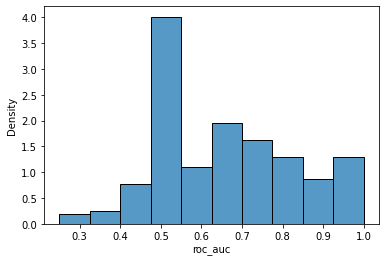

<Figure size 432x288 with 0 Axes>

  0%|          | 0/383 [00:00<?, ?it/s]

daily_shifts
Accuracy: 60.40%
F1Score:  0.5660298131429772
Precision Score:  0.5768078733418913
Recall Score:  0.5556471558120363
ROC AUC Score:  0.6008371784786739


/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWar

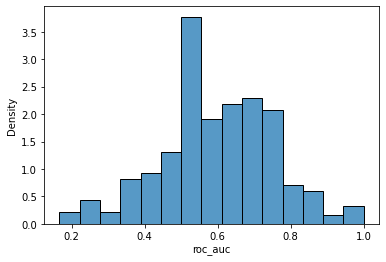

<Figure size 432x288 with 0 Axes>

  0%|          | 0/383 [00:00<?, ?it/s]

shift_stress
Accuracy: 80.98%
F1Score:  0.6894977168949772
Precision Score:  0.7365853658536585
Recall Score:  0.648068669527897
ROC AUC Score:  0.768017737253575


/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: Un

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: Un

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: Un

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: Un

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: Un

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:

/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1570: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/h/snagaraj/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:

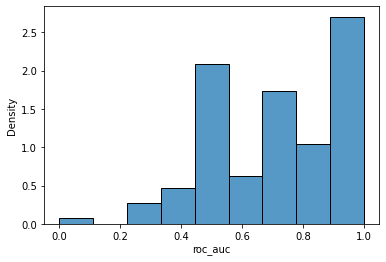

<Figure size 432x288 with 0 Axes>

In [96]:
participants_all = []
accs_all = []
f1s_all = []
precs_all = []
recs_all = []
roc_aucs_all = []
targets = []

recoded = {"daily_stressed": "Daily Stress", "daily_shifts": "Daily Shifts", "shift_stress": "Shift Stress"}

for target in ["daily_stressed","daily_shifts", "shift_stress"]:
    x_train, y_train, p_train, x_test, y_test, p_test = construct_dataset(merged_df, target, "oura+surveys")
    print(target)
    
    model, participants, accs, f1s, precs, roc_aucs = train_evaluate_xgb(x_train, y_train, p_train, x_test, y_test, p_test)
    
    for i in range(len(participants)):
        participants_all.append(participants[i])
        accs_all.append(accs[i])
        f1s_all.append(f1s[i])
        precs_all.append(precs[i])
        recs_all.append(recs[i])
        roc_aucs_all.append(roc_aucs[i])
        targets.append(recoded[target])
        

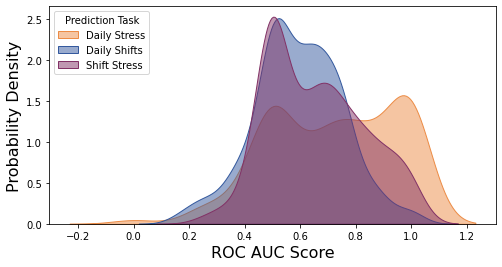

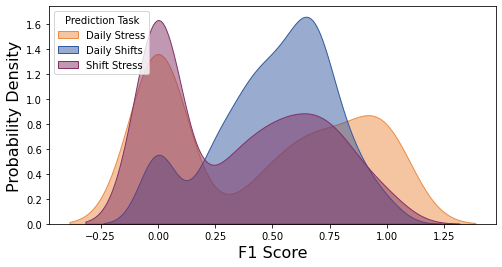

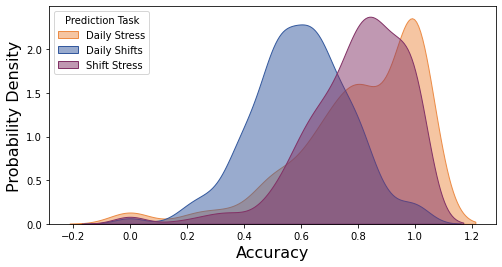

In [115]:
df_all = {"participant":participants_all, "accuracy":accs_all, "precision":precs_all, "recall":recs_all, "f1":f1s_all, "roc_auc":roc_aucs_all, "target": targets}

df_all = pd.DataFrame(df_all)

#df_all.sort_values(by=['roc_auc'], ascending=False)
measure_recoded = {"roc_auc": "ROC AUC Score", "f1": "F1 Score", "accuracy": "Accuracy", "precision": "Precision", "recall":"Recall"}

for measure in ["roc_auc", "f1", "accuracy"]:
    plt.figure(figsize=(8,4))
    sns.kdeplot(x=measure, hue="target", data = df_all,fill=True, common_norm=False, palette=[evi_purple, evi_blue, evi_orange], alpha=.5)
    plt.ylabel('Probability Density', fontsize=16)
    plt.xlabel(measure_recoded[measure], fontsize=16)
    plt.legend(title='Prediction Task', loc='upper left', labels=["Daily Stress", "Daily Shifts", "Shift Stress"])
    plt.show()